### Here I'm trying to predict the "preliminary decision" about a book based of its reviews

#### Important: Run this notebook after running " review_GitHub.ipynb "

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

### Exploratory Data Analysis(EDA)

In [3]:
df1 = pd.read_csv('decision.csv', index_col = 0)

df1

,book_id,preliminary_decision,review
0,1,accept,"[{'confidence': '4', 'evaluation': '1', 'id': ..."
1,2,accept,"[{'confidence': '4', 'evaluation': '2', 'id': ..."
2,3,accept,"[{'confidence': '4', 'evaluation': '2', 'id': ..."
3,4,accept,"[{'confidence': '4', 'evaluation': '2', 'id': ..."
4,5,accept,"[{'confidence': '4', 'evaluation': '2', 'id': ..."
...,...,...,...
167,168,accept,"[{'confidence': '3', 'evaluation': '2', 'id': ..."
168,169,accept,"[{'confidence': '3', 'evaluation': '1', 'id': ..."
169,170,reject,"[{'confidence': '5', 'evaluation': '-1', 'id':..."
170,171,accept,"[{'confidence': '4', 'evaluation': '-1', 'id':..."


In [4]:
df1.preliminary_decision.value_counts()

accept             115
reject              48
probably reject      7
no decision          2
Name: preliminary_decision, dtype: int64

accept             66.86
reject             27.91
probably reject     4.07
no decision         1.16
Name: preliminary_decision, dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

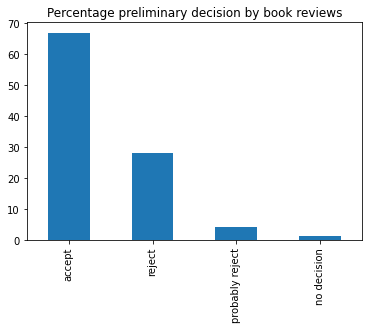

In [5]:
# Normalize and Plot  the preliminary decision
print(round(df1.preliminary_decision.value_counts(normalize=True)*100, 2))
round(df1.preliminary_decision.value_counts(normalize=True)*100, 2).plot(kind='bar')
plt.title('Percentage preliminary decision by book reviews')
plt.show


In [6]:
# Read the lemmatize CSV file into a dataframe

df2 = pd.read_csv('lemma.csv', index_col = 0)

df2

,level_0,confidence,evaluation,id,lan,orientation,remarks,text,timespan,length,new_text,Lemma_text,Lemma_length
0,0,4.0,1,1,es,0,NaN,- El artículo aborda un problema contingente y...,2010-07-05,575,artículo aborda problema contingente y relevan...,artículo abordo problema contingente y relevan...,331
1,0,4.0,1,2,es,1,NaN,El artículo presenta recomendaciones prácticas...,2010-07-05,618,artículo presenta recomendaciones prácticas de...,artículo presentar recomendación práctico desa...,433
2,0,5.0,1,3,es,1,NaN,- El tema es muy interesante y puede ser de mu...,2010-07-05,1259,tema interesante y ayuda guía incorporar práct...,tema interesante y ayuda guío incorporar práct...,731
3,1,4.0,2,1,es,1,NaN,Se explica en forma ordenada y didáctica una e...,2010-07-05,1350,explica forma ordenada y didáctica experiencia...,explicar forma ordenado y didáctico experienci...,911
4,1,4.0,2,3,es,0,NaN,Los autores describen una metodología para des...,2010-07-05,1938,autores describen metodología desarrollar form...,autor describir metodología desarrollar forma ...,1178
...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,169,5.0,-1,1,es,-2,NaN,El trabajo pretende ofrecer una visión del uso...,2015-07-05,684,pretende ofrecer visión herramientas eva entor...,pretender ofrecer visión herramienta eva entor...,357
395,169,4.0,-1,2,es,-1,NaN,El paper está bien escrito y de fácil lectura....,2015-07-05,576,paper escrito y fácil lectura ajusta formato e...,paper escrito y fácil lectura ajusto formato e...,359
396,170,4.0,-1,1,es,0,NaN,Observación de fondo: No se presenta un ejemp...,2015-07-05,831,observación fondo presenta implementación inte...,observación fondo presentar implementación int...,469
397,170,3.0,1,2,es,-1,NaN,Se propone un procedimiento para elaborar máqu...,2015-07-05,472,propone procedimiento elaborar máquinas dispos...,proponer procedimiento elaborar máquina dispos...,292


In [7]:
df2.dtypes

level_0           int64
confidence      float64
evaluation        int64
id                int64
lan              object
orientation       int64
remarks          object
text             object
timespan         object
length            int64
new_text         object
Lemma_text       object
Lemma_length      int64
dtype: object

In [8]:
# Analytical summary 

df2.describe(include= 'all')

,level_0,confidence,evaluation,id,lan,orientation,remarks,text,timespan,length,new_text,Lemma_text,Lemma_length
count,382.000000,380.000000,382.000000,382.000000,382,382.000000,109,382,382,382.000000,382,382,382.000000
unique,NaN,NaN,NaN,NaN,1,NaN,106,382,4,NaN,382,382,NaN
top,NaN,NaN,NaN,NaN,es,NaN,Claramente se trata de un artículo académico r...,"El manuscrito involucra el uso de GPU, tecnolo...",2014-07-05,NaN,artículo realiza estudio bibliográfico interes...,general recomeir cambio título artículo realme...,NaN
freq,NaN,NaN,NaN,NaN,382,NaN,2,1,125,NaN,1,1,NaN
mean,86.065445,3.568421,0.133508,1.832461,NaN,-0.225131,NaN,NaN,NaN,1033.162304,NaN,NaN,626.633508
std,48.741252,0.858330,1.509542,0.824935,NaN,1.035636,NaN,NaN,NaN,838.710628,NaN,NaN,508.330644
min,0.000000,1.000000,-2.000000,1.000000,NaN,-2.000000,NaN,NaN,NaN,41.000000,NaN,NaN,13.000000
25%,41.000000,3.000000,-1.000000,1.000000,NaN,-1.000000,NaN,NaN,NaN,493.250000,NaN,NaN,307.000000
50%,92.500000,4.000000,0.000000,2.000000,NaN,0.000000,NaN,NaN,NaN,814.500000,NaN,NaN,492.000000
75%,125.750000,4.000000,2.000000,2.000000,NaN,1.000000,NaN,NaN,NaN,1326.250000,NaN,NaN,797.000000


array([[<AxesSubplot:title={'center':'level_0'}>,
        <AxesSubplot:title={'center':'confidence'}>,
        <AxesSubplot:title={'center':'evaluation'}>],
       [<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'orientation'}>,
        <AxesSubplot:title={'center':'length'}>],
       [<AxesSubplot:title={'center':'Lemma_length'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

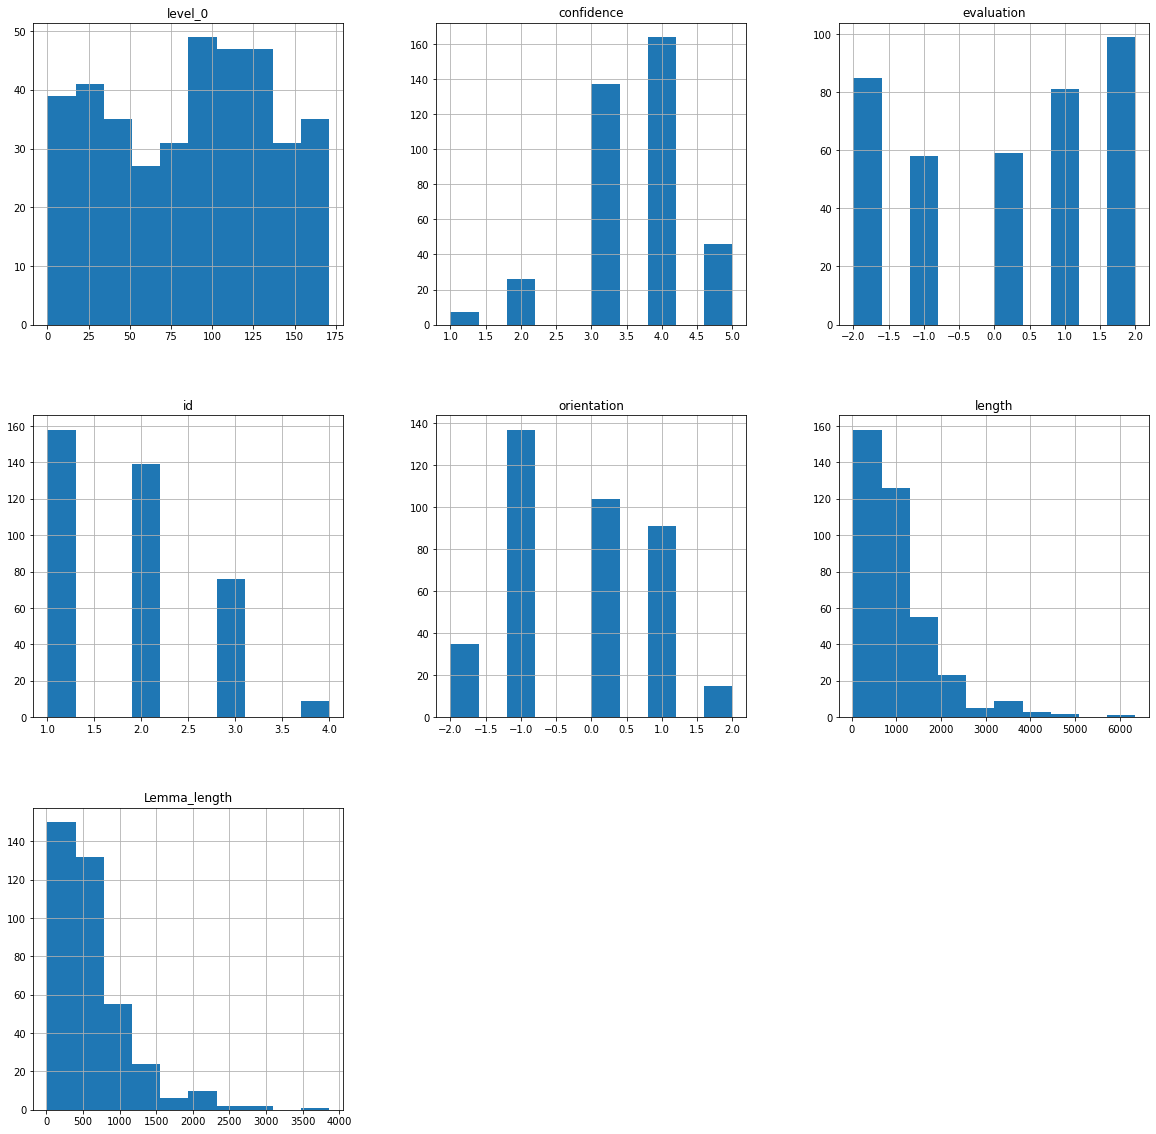

In [9]:
# Histogramm

df2.hist(figsize = (20, 20))

<AxesSubplot:xlabel='Lemma_length'>

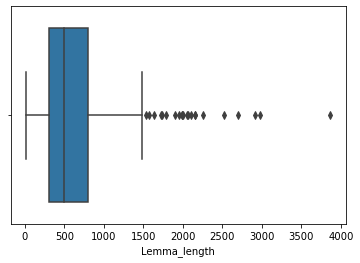

In [10]:
# finding outlier in the texts'length
sns.boxplot(x = df2['Lemma_length'])

,confidence,evaluation,orientation,Lemma_length
confidence,1.000000,-0.042972,-0.063010,0.048558
evaluation,-0.042972,1.000000,0.773099,-0.249051
orientation,-0.063010,0.773099,1.000000,-0.243826
Lemma_length,0.048558,-0.249051,-0.243826,1.000000


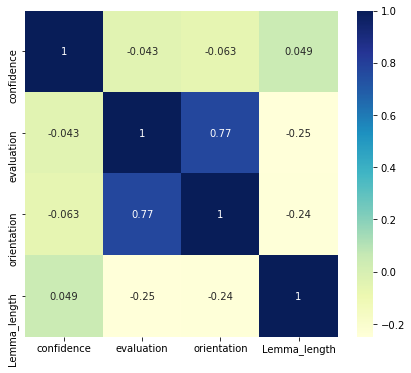

In [11]:
# Finding relationship between the variables
plt.figure(figsize=(7,6))
rel = df2[['confidence','evaluation', 'orientation', 'Lemma_length']].corr()
sns.heatmap(rel, cmap = "YlGnBu", annot=True)
rel

In [12]:
## 0.77, show us that there is a high and positive correlation between "Orientation" and "evaluation"

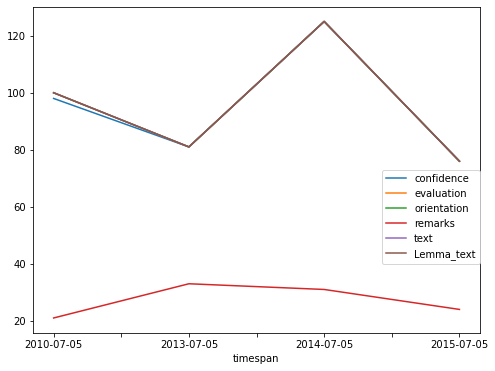

In [13]:
# Years plot

df2[["confidence", "evaluation", "orientation", "remarks", "text", "Lemma_text"]].groupby([df2['timespan']]).count().plot(kind='line', figsize = (8,6))
plt.legend(bbox_to_anchor=(1, 0.5), loc=1, borderaxespad=0)

<AxesSubplot:xlabel='timespan', ylabel='count'>

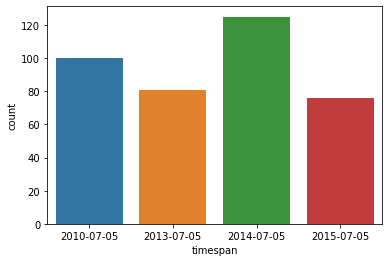

In [14]:
#Estimate the number of reviews per year

sns.countplot(x ='timespan', data = df2)

4.0    43.16
3.0    36.05
5.0    12.11
2.0     6.84
1.0     1.84
Name: confidence, dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

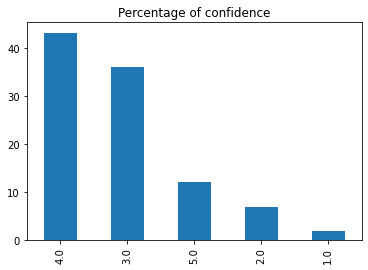

In [15]:
# # Checking 'confidence' column
print(round(df2.confidence.value_counts(normalize=True)*100, 2))
round(df2.confidence.value_counts(normalize=True)*100, 2).plot(kind='bar')
plt.title('Percentage of confidence')
plt.show

 2    25.92
-2    22.25
 1    21.20
 0    15.45
-1    15.18
Name: evaluation, dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

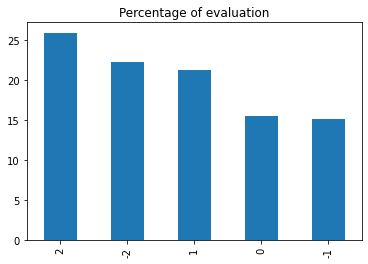

In [16]:
# Checking the 'evaluation' colums
print(round(df2.evaluation.value_counts(normalize=True)*100, 2))
round(df2.evaluation.value_counts(normalize=True)*100, 2).plot(kind='bar')
plt.title('Percentage of evaluation')
plt.show

-1    35.86
 0    27.23
 1    23.82
-2     9.16
 2     3.93
Name: orientation, dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

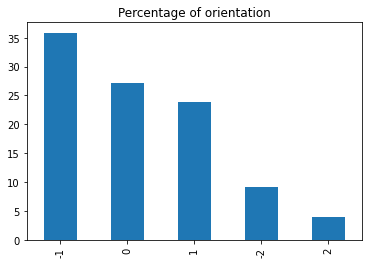

In [17]:
# Checking the 'orientation' column
print(round(df2.orientation.value_counts(normalize=True)*100, 2))
round(df2.orientation.value_counts(normalize=True)*100, 2).plot(kind='bar')
plt.title('Percentage of orientation')
plt.show

### Predict the preliminare_decision

In [18]:
# Extract 2 columns: level_0 and Lemma_text

In [19]:
df2_new = df2[['level_0','Lemma_text']]

df2_new.head()

,level_0,Lemma_text
0,0,artículo abordo problema contingente y relevan...
1,0,artículo presentar recomendación práctico desa...
2,0,tema interesante y ayuda guío incorporar práct...
3,1,explicar forma ordenado y didáctico experienci...
4,1,autor describir metodología desarrollar forma ...


In [20]:
# Checking 1st row before concatanation
df2_new['Lemma_text'][0]

'artículo abordo problema contingente y relevante e incluir diagnóstico nacional práctico solución práctico concreto lenguaje adecuado artículo sentir concatenación artículo resultado encuesta práctico seguridad incorporación práctico ordir sección reflejo orden versión revisado artículo validación tipo siquiera evaluación experto'

In [21]:
# Merge rows by same value in the column ('level_0')
d = {'Lemma_text': lambda x: ' '.join(x)}
df_new = df2_new.groupby(df2_new['level_0']).aggregate(d)
df_new.head()

,Lemma_text
level_0,
0,artículo abordo problema contingente y relevan...
1,explicar forma ordenado y didáctico experienci...
2,proponer enfocar basado apoyar recomendación r...
3,realizar modelamiento encriptación cuánticar n...
4,novedoso propuesta estructurado correctamente ...


In [22]:
# Checking if the rows are well concatenated
df_new['Lemma_text'][0]

'artículo abordo problema contingente y relevante e incluir diagnóstico nacional práctico solución práctico concreto lenguaje adecuado artículo sentir concatenación artículo resultado encuesta práctico seguridad incorporación práctico ordir sección reflejo orden versión revisado artículo validación tipo siquiera evaluación experto artículo presentar recomendación práctico desarrollo software seguro describir mejor práctica recomendado desarrollar software proactivo ataque y realizar análisis costo práctico desarrollo software basado revisión práctico propuesto bibliografío y contraste dato obtenido encuesta empresa finalmente recomendar guía ideal aplicar guía propuesto empresa involucrado encuesta servir originar él evaluar efectividad forma independiente tema interesante y ayuda guío incorporar práctica seguridad presentación descripción etapa y práctica desarrollo software seguro real desarrollo software chile indicar paper lograr encuesta presentar nueve tabla corresponder práctica

In [23]:
## Merge two dataframes
df_merge = pd.merge(df1, df_new, left_index=True, right_index=True)
df_merge.head()

,book_id,preliminary_decision,review,Lemma_text
0,1,accept,"[{'confidence': '4', 'evaluation': '1', 'id': ...",artículo abordo problema contingente y relevan...
1,2,accept,"[{'confidence': '4', 'evaluation': '2', 'id': ...",explicar forma ordenado y didáctico experienci...
2,3,accept,"[{'confidence': '4', 'evaluation': '2', 'id': ...",proponer enfocar basado apoyar recomendación r...
3,4,accept,"[{'confidence': '4', 'evaluation': '2', 'id': ...",realizar modelamiento encriptación cuánticar n...
4,5,accept,"[{'confidence': '4', 'evaluation': '2', 'id': ...",novedoso propuesta estructurado correctamente ...


In [24]:
# Drop review column
df_merge_New = df_merge.drop(['review'], axis =1)
df_merge_New.head()

,book_id,preliminary_decision,Lemma_text
0,1,accept,artículo abordo problema contingente y relevan...
1,2,accept,explicar forma ordenado y didáctico experienci...
2,3,accept,proponer enfocar basado apoyar recomendación r...
3,4,accept,realizar modelamiento encriptación cuánticar n...
4,5,accept,novedoso propuesta estructurado correctamente ...


In [25]:
# Before dropping some rows
df_merge_New.shape

(168, 3)

In [26]:
# Drop 'probably reject' & 'no decision' rows 

#df_merge_New.drop(df_merge_New[(df_merge_New['preliminary_decision'] == 'no decision') & (df_merge_New['preliminary_decision'] == 'probably reject') ].index , inplace=True)

df_merge_New.drop(df_merge_New[df_merge_New['preliminary_decision'] == 'probably reject' ].index , inplace=True)

df_merge_New.drop(df_merge_New[df_merge_New['preliminary_decision'] == 'no decision' ].index , inplace=True)

df_merge_New.shape


(160, 3)

In [27]:
df_merge_New['preliminary_decision'].unique()

array(['accept', 'reject'], dtype=object)

accept    70.0
reject    30.0
Name: preliminary_decision, dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

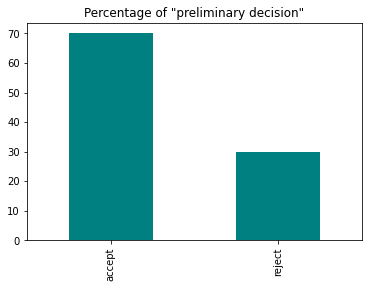

In [28]:
# Normalize and Plot the preliminary decision column after dropping "probably rejected" and "no decision" rows

print(round(df_merge_New.preliminary_decision.value_counts(normalize=True)*100, 2))
round(df_merge_New.preliminary_decision.value_counts(normalize=True)*100, 2).plot(kind='bar', color = 'teal')
plt.title('Percentage of "preliminary decision"')
plt.show

In [29]:
# Reset indexes

df_merge_New.reset_index(drop=True, inplace=True)

#df_merge_New.info()
df_merge_New


,book_id,preliminary_decision,Lemma_text
0,1,accept,artículo abordo problema contingente y relevan...
1,2,accept,explicar forma ordenado y didáctico experienci...
2,3,accept,proponer enfocar basado apoyar recomendación r...
3,4,accept,realizar modelamiento encriptación cuánticar n...
4,5,accept,novedoso propuesta estructurado correctamente ...
...,...,...,...
155,167,reject,problema formar identificado figura claro cont...
156,168,accept,interesante requerir muestra estadístico ampli...
157,169,accept,documento describir exploratorio desarrollo ap...
158,170,reject,pretender ofrecer visión herramienta eva entor...


### Model training

In [31]:
from sklearn.model_selection import train_test_split

independent_var = df_merge_New.Lemma_text
target_var = df_merge_New.preliminary_decision

X_train, X_test, y_train, y_test = train_test_split(independent_var, target_var, random_state = 13) 

print('X_train: ', len(X_train))
print('X_test: ', len(X_test))
print('y_train: ', len(y_train))
print('y_test: ', len(y_test))

X_train:  120
X_test:  40
y_train:  120
y_test:  40


### Vectorization Feature Engineering (TF-IDF)

In [32]:
#tfvec = TfidfVectorizer(ngram_range=(1,2))
cv = CountVectorizer(ngram_range=(1, 2))
clf = LogisticRegression(solver = "liblinear") # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#clf = LinearSVC() # This has increase the ccuracy

model = Pipeline([('vectorizer', cv), ('classifier', clf)])

# Train the Classifier
model.fit(X_train, y_train)

#Predict the response for test dataset
predictions = model.predict(X_test)

#Create a confusion matrix
confusion_matrix( y_test, predictions)

# Model Accuracy, how often is the classifier correct?
print("Accuracy: ", accuracy_score( y_test, predictions ))

# print("Precision: ", precision_score(predictions, y_test, average = 'weighted' ) )
# print("Recall: ", recall_score(predictions, y_test, average = 'weighted', labels=np.unique(predictions)))

Accuracy:  0.8


In [33]:
# classification_report() builds a text report showing the main classification metrics.

print(classification_report(y_test, predictions))# , labels=np.unique(predictions)))


              precision    recall  f1-score   support

      accept       0.83      0.94      0.88        32
      reject       0.50      0.25      0.33         8

    accuracy                           0.80        40
   macro avg       0.67      0.59      0.61        40
weighted avg       0.77      0.80      0.77        40



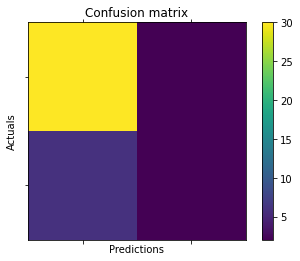

In [34]:
# plot the confusion matrix

#labels = ['accept', 'reject']
cm = confusion_matrix(y_test, predictions)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] )
ax.set_yticklabels([''] )
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.show()

In [35]:
### Try a new review

review = ['su novela es una historia mágica que revela la esencia de la vida, el amor y la soledad. Debido a la simplicidad del estilo de la prosa, las ilustraciones divertidas y divertidas, la viveza de la imaginación, esta historia simple pero reveladora se considera una de las mejores obras literarias de todos los tiempos.']
result = model.predict(review)

print(result)

['accept']


### Countvectorizer and  Naive Bayes classifier

In [36]:
##################

X = df_merge_New.Lemma_text
y = df_merge_New.preliminary_decision
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)

cv = CountVectorizer(ngram_range=(1, 2))
clf = MultinomialNB()

naive_bayes = Pipeline([('vectorizer', cv), ('classifier', clf)])

# Fit the model and make predictions

naive_bayes.fit(X_train, y_train)

predictions = naive_bayes.predict(X_test)

# # Model Accuracy, how often is the classifier correct?

print('Accuracy score: ', accuracy_score(y_test, predictions))

Accuracy score:  0.7


In [37]:
# Create a confusion matrix
conf_mnNB = confusion_matrix(y_test, predictions)

conf_mnNB

array([[26,  6],
       [ 6,  2]], dtype=int64)

In [38]:
# classification_report() builds a text report showing the main classification metrics.

print(classification_report(y_test, predictions, labels=np.unique(predictions)))

              precision    recall  f1-score   support

      accept       0.81      0.81      0.81        32
      reject       0.25      0.25      0.25         8

    accuracy                           0.70        40
   macro avg       0.53      0.53      0.53        40
weighted avg       0.70      0.70      0.70        40



### DecisionTreeClassifier’

In [39]:

X = df_merge_New.Lemma_text
y = df_merge_New.preliminary_decision

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Create Decision Tree classifer object
clf= DecisionTreeClassifier()

cv = CountVectorizer(ngram_range=(1, 2))
#tfvec = TfidfVectorizer(ngram_range=(1,2))

pipe_DTC = Pipeline(steps = [('vectorizer', cv),('classifire', clf)])

# Train Decision Tree Classifier
pipe_DTC.fit(X_train,y_train)

#Predict the response for test dataset
pred = pipe_DTC.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy_score(y_test, pred))


Accuracy: 0.65625


In [40]:
# Create a confusion matrix
conf_DT = confusion_matrix(y_test, pred)

conf_DT


array([[19,  6],
       [ 5,  2]], dtype=int64)

In [41]:
# Decision Tree classification

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

      accept       0.79      0.76      0.78        25
      reject       0.25      0.29      0.27         7

    accuracy                           0.66        32
   macro avg       0.52      0.52      0.52        32
weighted avg       0.67      0.66      0.66        32

